In [1]:
import torch
from torch import nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import mat73
import scipy.io as sio
import sys
from timeit import default_timer as timer
import plotly
import plotly.graph_objs as go
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import open3d as o3d
from torch import nn
import math
np.set_printoptions(threshold=sys.maxsize)

# from utilsReal.optim import Model, training_loop, bruteForce
# from utilsReal.generateBasis import generateBasisFunction
from utilsReal.helper import computeVisibility3D, pulse, lowPassFilter
from utilsReal.shape import carving

# Import Time Profiles and Visibility Matrix

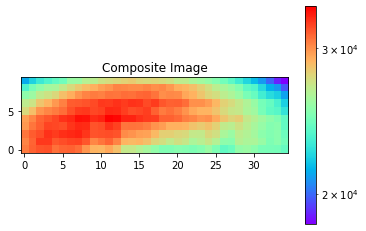

In [2]:
#####################################################################
####################### IMPORT TIME PROFILES ########################
#####################################################################

# data parameters
bin_width = 8E-12
t0 = 14.2428e-9; bin0 = round(t0 / bin_width)
numBins = 8192 - bin0
t = np.linspace(0, bin_width * (numBins-1), numBins)

# plot parameters
plotImgs = False

# detector parameters
num_u = 35; num_v = 10 # dimension of video
det_locs = sio.loadmat('../../data/multiplexed_twobounce_021322/results.mat')['x_p']
# det_locs = np.reshape(det_locs, (num_v, num_u, 3))
nc = np.array([0, 0, 1])

# laser parameters
numSpots_x = 10; numSpots_y = 5
las_locs = np.transpose(sio.loadmat('../../data/multiplexed_twobounce_021322/results.mat')['D'])
# las_locs = np.reshape(las_locs, (numSpots_y, numSpots_x, 3))

# import reference pulse
filename = '../../data/Bounce Flash/replica.mat'
pulseShape = np.squeeze(sio.loadmat(filename)['replica'])[bin0:]
pulseShape = np.roll(pulseShape, 50-np.argmax(pulseShape))
pulseShape = pulseShape / np.max(pulseShape)

# import histograms and visibility matrix
indiv_hists = np.zeros((numSpots_y, numSpots_x, num_v, num_u, numBins)) 
observation = np.zeros((num_v, num_u, numBins))
vis_gt = np.zeros((numSpots_y, numSpots_x, num_v, num_u))
i = 0
for y in range(numSpots_y):
    for x in range(numSpots_x):
        num = str(i+1)
        filename = '../../data/multiplexed_twobounce_021322/shadow_spot_' + num + '.mat'
        dataCube = mat73.loadmat(filename)['dataCube']
        dataCube_r = np.reshape(dataCube[:, bin0:], (num_v, num_u, numBins))
        
        if (y+1) % 2 == 1:
            x_idx = x
        else: 
            x_idx = numSpots_x - x - 1
        indiv_hists[y, x_idx, :, :, :] = dataCube_r
        observation += dataCube_r 
        
        t_int = np.sum(dataCube_r, 2)
        vis_gt[y, x_idx, :, :] = t_int

        # plot time-integrated images
        if plotImgs:
            plt.figure(); plt.title('y = ' + str(y+1) + ', x = ' + str(x_idx+1))
            im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
            plt.colorbar(im)
        i += 1
        
# # indiv_hists2 = lowPassFilter(t, indiv_hists, bin_width, 0.7E10, False)
# observations = np.sum(indiv_hists, axis=1)

# plot superimposed image
plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(observation, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)
plt.show()

/var/folders/4p/0q_dfsrd3x13x_xh9k0_vc2r0000gn/T/ipykernel_66849/1646269295.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(); plt.title('y = ' + str(y+1) + ', x = ' + str(x+1))


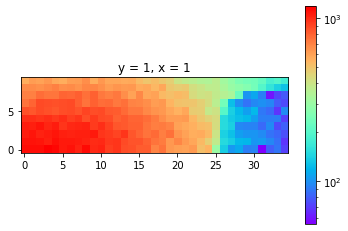

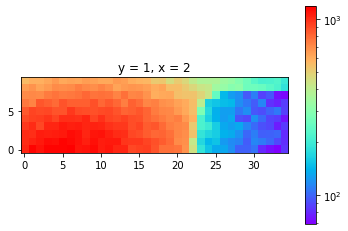

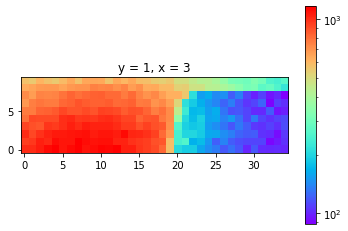

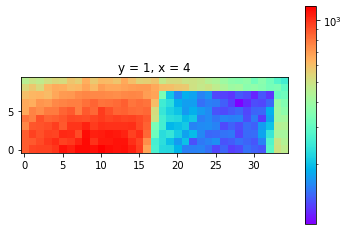

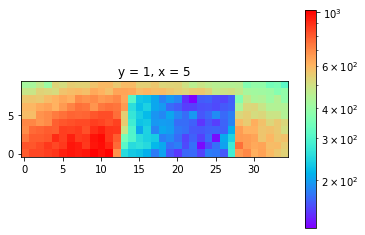

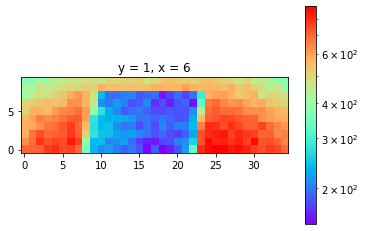

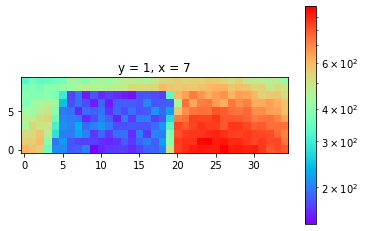

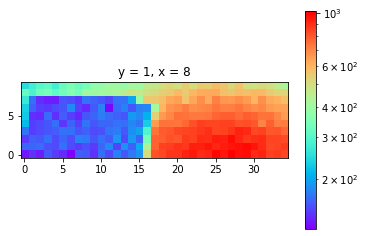

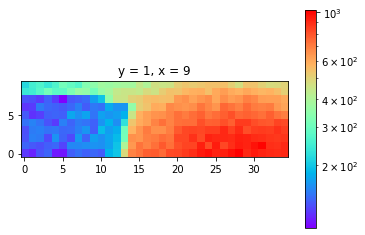

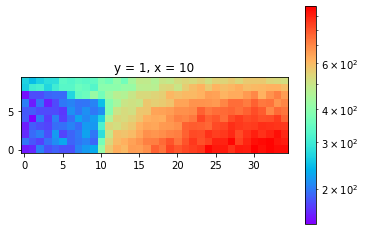

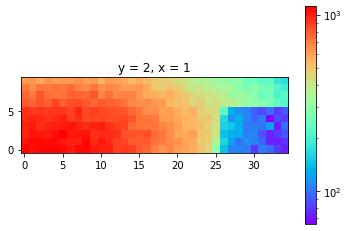

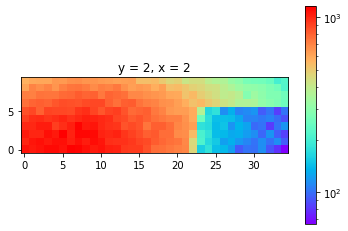

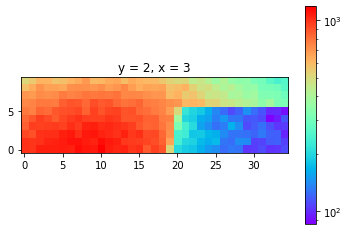

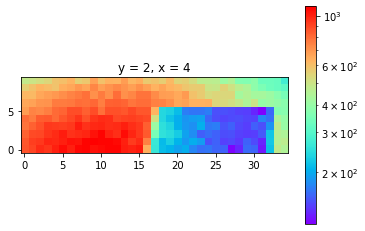

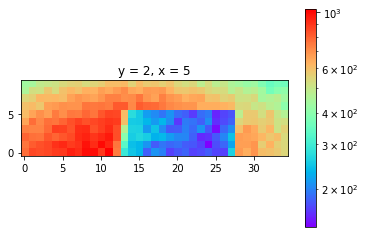

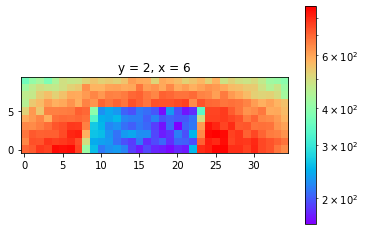

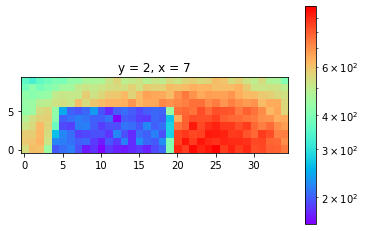

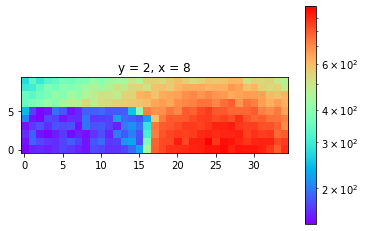

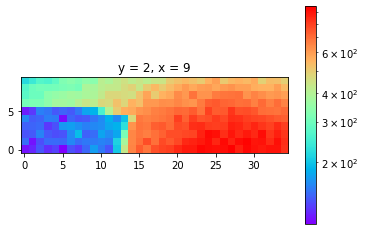

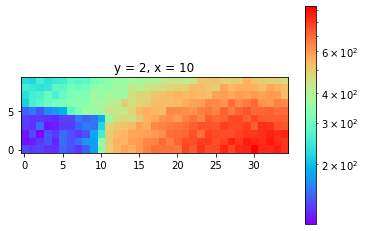

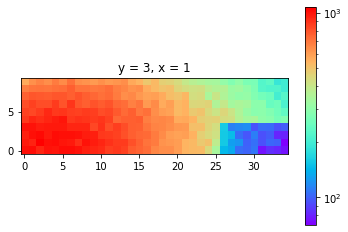

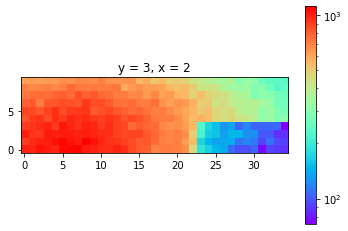

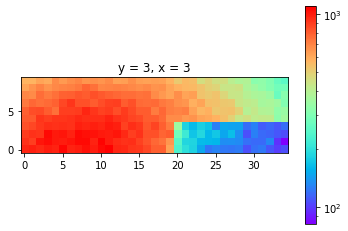

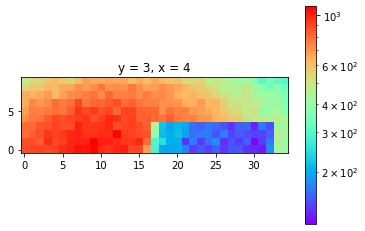

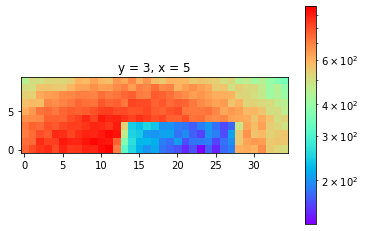

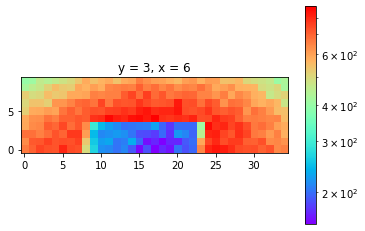

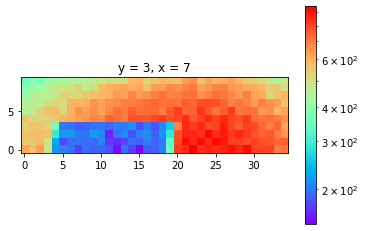

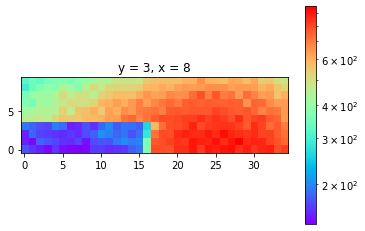

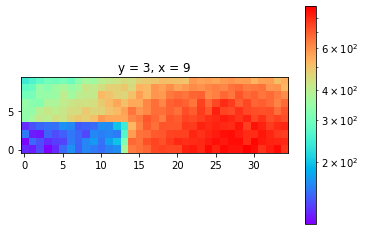

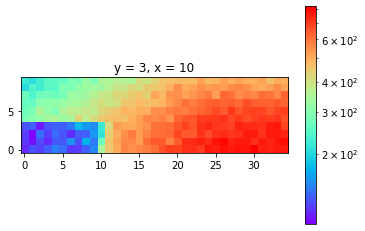

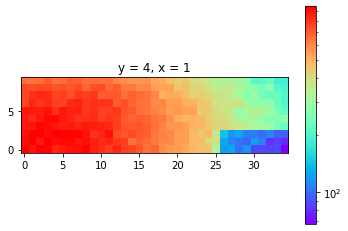

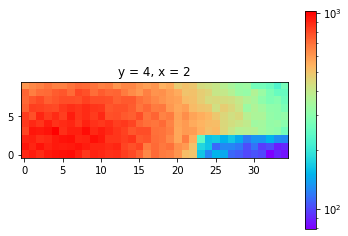

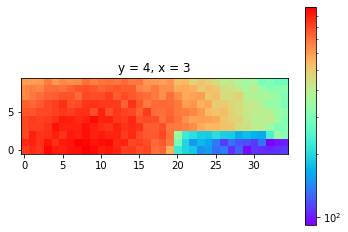

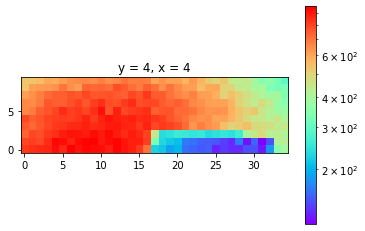

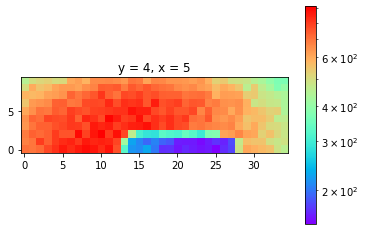

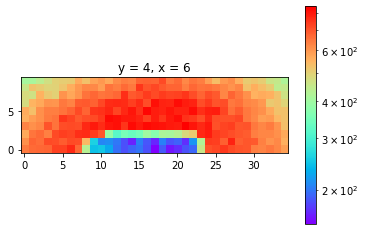

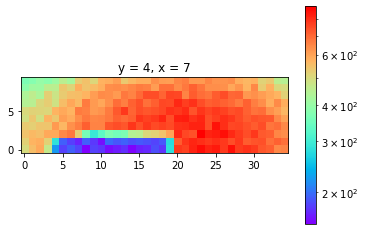

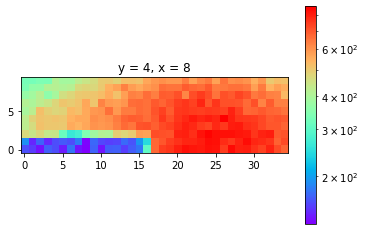

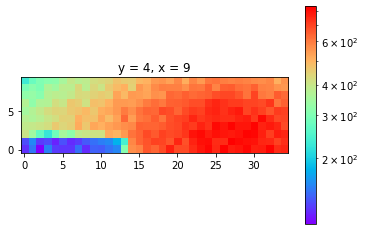

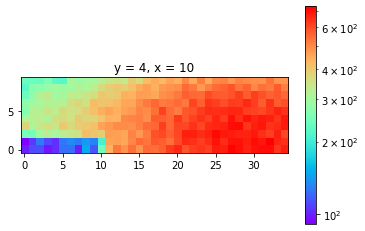

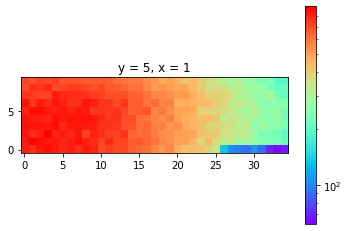

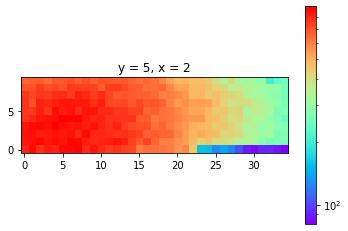

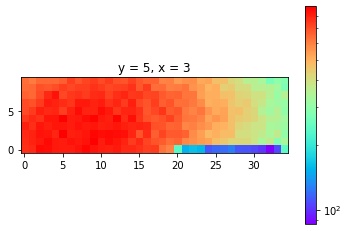

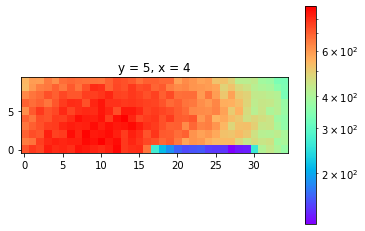

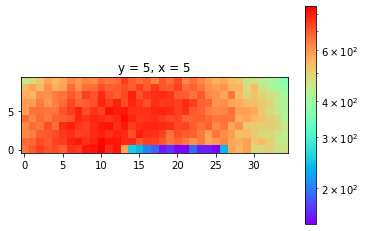

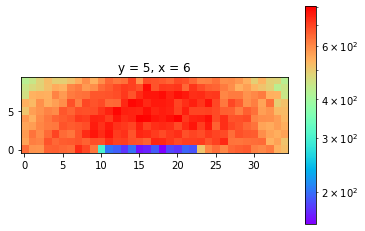

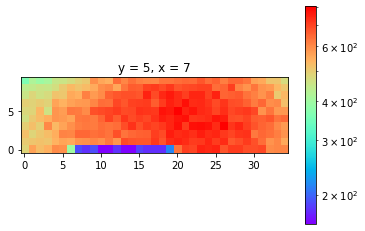

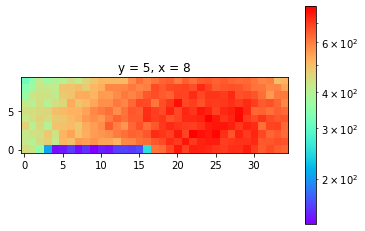

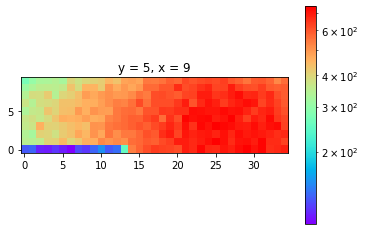

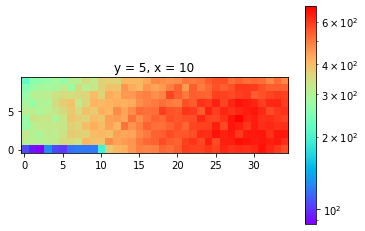

In [3]:
# plot visibility matrix
for y in range(numSpots_y):
    for x in range(numSpots_x):
        plt.figure(); plt.title('y = ' + str(y+1) + ', x = ' + str(x+1))
        im = plt.imshow(vis_gt[y, x, :, :], cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
        plt.colorbar(im)

[1.41196776 1.39151311 1.3718287  1.35155233 1.33157301 1.31154437
 1.29170631 1.27146513 1.25140353 1.23174364 1.21114139 1.19131557
 1.17127036 1.15150512 1.1314214  1.11123481 1.09149709 1.07131303
 1.0516086  1.0320261  1.01203438 0.99234962 0.9730432  0.9534166
 0.93325638 0.91394637 0.89423946 0.87464907 0.8548543  0.83593109
 0.8166588  0.79674463 0.77755899 0.7584566  0.73883612]
(10, 35, 3)


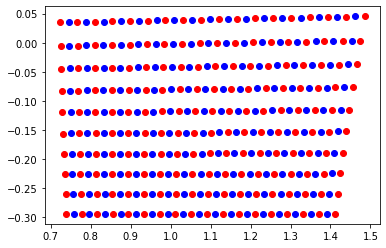

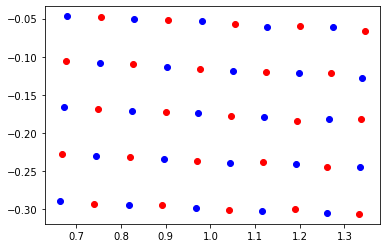

In [10]:
dets = np.reshape(det_locs, (num_v, num_u, 3))
lass = np.reshape(las_locs, (numSpots_y, numSpots_x, 3))

# detector order is reversed (farthest z to closest x) 
# laser order is scan along x, then move up along y in continuous motion (same for detector)

print(dets[0, :, 2])
print(dets.shape)
plt.figure()
for i in range(num_u):
    if i%2== 0:
        plt.plot(dets[:, i, 2], dets[:, i, 1], 'or')
    else:
        plt.plot(dets[:, i, 2], dets[:, i, 1], 'ob')
    
plt.figure()
for i in range(numSpots_x):
    if i%2== 0:
        plt.plot(lass[:, i, 2], lass[:, i, 1], 'or')
    else:
        plt.plot(lass[:, i, 2], lass[:, i, 1], 'ob')

# Plot Point Cloud

In [5]:
# Save x, y, z data to .ply file if needed
comb_locs = np.vstack((dets[:, :, :], lass[:, :, :]))
if True:
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(comb_locs)
    o3d.io.write_point_cloud("../../data/multiplexed_twobounce_021322/comb.ply", pcd)

# Visualize point cloud (WARNING: This will open another window and you will be forced to kill kernal)
if True:
    cloud = o3d.io.read_point_cloud("../../data/multiplexed_twobounce_021322/comb.ply") # Read the point cloud
    o3d.visualization.draw_geometries([cloud])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 35 and the array at index 1 has size 10

# Helper Functions

In [ ]:
def generateBasisFunction(las_locs, det_locs, t, pulseShape, bin_width, c):
    # inputs:
    #     src_locs - (x, y) pixels (numPixels x 3)
    #     det_locs - (x, y) pixels (numSpots x 3)
    #
    # output: 
    #     hists    - only pixels of interest (numPixels x numSpots x numBins)
    
    # constant parameters
    numPixels = det_locs.shape[0]
    numSpots = las_locs.shape[0]
    numBins = len(t)
    
    # define variables
    det_x = np.tile(np.reshape(det_locs[:, 0], (numPixels, 1)), (1, numSpots))
    det_y = np.tile(np.reshape(det_locs[:, 1], (numPixels, 1)), (1, numSpots))
    det_z = np.tile(np.reshape(det_locs[:, 2], (numPixels, 1)), (1, numSpots))
    
    las_x = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1))
    las_y = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1))
    las_z = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1))
    
    # compute tof
    r1 = (las_x**2 + las_y**2 + las_z**2)**0.5 
    r2 = ((det_x-las_x)**2 + (det_y-las_y)**2 + (det_z-las_z)**2)**0.5
    r3 = (det_x**2 + det_y**2 + det_z**2)**0.5
    pathLen = r1 + r2 + r3
    tof = (pathLen / c) #- t0
    
    # create array of pulses in fourier domain
    pulse_fft = np.reshape(np.fft.fft(np.squeeze(pulseShape)), (1, 1, numBins)) # 1 x 1 x numBins
    pulses_fft = np.tile(pulse_fft, (numPixels, numSpots, 1)) # numPixels x x numSpots x numBins
    f = np.reshape(np.fft.fftfreq(numBins, bin_width), (1, 1, numBins)) # 1 x 1 x numBins
    f_tiled = np.tile(f, (numPixels, numSpots, 1)) # numPixels x numSpots x numBins
    
    # shift pulses by tof
    tof_r = np.reshape(tof, (numPixels, numSpots, 1))
    freq_shift = pulses_fft * np.exp(-1j*2*math.pi*f_tiled*tof_r) 
    hists = np.abs(np.fft.ifft(freq_shift)) # assume pulse is completely positive. if not, use np.real()
    
#     # attenuation by albedo, r^2 falloff, cosine falloff (NOTE: make sure albedo values are reasonable)
#     r2_squared = r2**2
#     r3_squared = r3**2
    
#     rho1 = np.tile(np.reshape(albedo[las_yidx, las_xidx], (1, numSpots)), (numPixels, 1))
#     rho2 = np.tile(np.reshape(albedo[det_yidx, det_xidx], (numPixels, 1)), (1, numSpots))
    
#     n1 = np.tile(np.reshape(n_vector[las_yidx, las_xidx, :], (1, numSpots, 3)), (numPixels, 1, 1))
#     n2 = np.tile(np.reshape(n_vector[det_yidx, det_xidx, :], (numPixels, 1, 3)), (1, numSpots, 1))

#     wc1_unnorm = np.tile(np.reshape(pt_loc[las_yidx, las_xidx, :], (1, numSpots, 3)), (numPixels, 1, 1))
#     wc1 = wc1_unnorm / np.reshape(np.sum(wc1_unnorm**2, 2)**0.5, (numPixels, numSpots, 1))
#     w1c = -wc1
#     wc2_unnorm = np.tile(np.reshape(pt_loc[det_yidx, det_xidx, :], (numPixels, 1, 3)), (1, numSpots, 1))
#     wc2 = wc2_unnorm / np.reshape(np.sum(wc2_unnorm**2, 2)**0.5, (numPixels, numSpots, 1))
#     w12_unnorm = wc2_unnorm - wc1_unnorm
#     w12 = w12_unnorm / np.reshape(np.sum(w12_unnorm**2, 2)**0.5, (numPixels, numSpots, 1))
#     w21 = -w12
    
#     nc = np.tile(np.reshape(nc, (1, 1, 3)), (numPixels, numSpots, 1))
#     a = rho1 * rho2 * (dot(w12, n1) * dot(w21, n2) * dot(wc2, nc) / r2_squared)
# #     a = (rho1 * dot(w1c, n1) / r2_squared) * (rho2 * dot(w21, n2) / r3_squared) * dot(wc2, nc)

#     hists *= scale * np.reshape(a, (numPixels, numSpots, 1)) 
    
    return tof, hists

class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, numPixels, numSpots):
        super().__init__()
        # initialize weights with random numbers
        vis = torch.rand(numPixels, numSpots)
        vis = torch.where(vis > 0.5, 1.0, 0.0)
        
        # make weights torch parameters
        self.vis = nn.Parameter(vis, requires_grad = True)      
        
    def forward(self, hists):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
#         vis = torch.sigmoid(self.vis)
        vis = self.vis
        obs = torch.sum(hists * vis.unsqueeze(-1), axis=1)
        return obs

def training_loop(model, histograms, observations, optimizer, thresh, lam, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        preds = model(histograms)
        loss1 = F.mse_loss(preds, observations) 
        loss2 = torch.sum(torch.square(torch.diff(model.vis, n=1, axis=0))) 
        loss = loss1 + lam * loss2
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

# Time Domain Optimization

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

i1 = 1300; i2 = 1800 
# i1 = 0; i2 = -1

# plot individual histograms
leg = []
plt.figure()
pixelHist = indiv_hists[i, 8, 5, i1:i2]
observation = np.zeros((num_v, num_u, numBins))
for i in range(20, 30-8):
    a = lowPassFilter(t, indiv_hists[i, 8, 5, :], bin_width, 2E10, False)
    a = moving_average(a, 10)
#     a = moving_average(indiv_hists[i, 8, 5, :], 1)
    observation += a
    plt.plot(t[i1:i2], a[i1:i2])
    leg.append('spot # ' + str(i+1))

# plot superimposed histogram
# observation = np.sum(indiv_hists[20:30, :, :, :] , axis=0)
print(observation.shape)
# plt.figure()
pixelHist = observation[8, 5, :]
plt.plot(t[i1:i2], pixelHist[i1:i2])
leg.append('Cumulative Histograms')
plt.plot(t[i1:i2], np.roll(10 * pulseShape, 1400)[i1:i2])
leg.append('Reference')
plt.legend(leg)

In [ ]:
detLocs = np.reshape(det_locs, (num_v, num_u, 3))
lasLocs = np.reshape(las_locs, (5, 10, 3))
print(detLocs.shape)
print(lasLocs.shape)

In [ ]:
#####################################################################
####### SOLVE INVERSE PROBLEM (RECONSTRUCT VISIBILITY MATRIX) #######
#####################################################################

y_srcs = 3
y_dets = 2
x_srcs_min = 0
x_srcs_max = numSpots_x
x_dets_min = 0
x_dets_max = num_u

vis2D = np.transpose(vis_gt[y_srcs, x_srcs_min:x_srcs_max, y_dets, x_dets_min:x_dets_max])

c = 299792458 # 3E8 / 1.0003

# optimization parameters
numIters = 3000
thresh = 1E-100
lr_rate = 0.1
lam = 1E-4 # 5E2 for noiseless case

# object parameters
pixelSize = 0.01 # meters

# plotting parameters
plotError = False
    
# generate basis functions
tof, hists = generateBasisFunction(lasLocs_line, detLocs_line, t, pulseShape, bin_width, c)
print(hists.shape)

# gradient descent
m = Model(numPixels, numSpots)
opt = torch.optim.Adam(m.parameters(), lr=lr_rate)

obs_filt = torch.tensor(obs)
hists_norm = torch.tensor(hists)

losses = training_loop(m, hists_norm, obs_filt, opt, thresh, lam, n=500)
vis = m.vis.detach()
# vis = torch.sigmoid(vis)
v_reconst = vis
# v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
# v_reconst = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

# plot optimization loss
if plotError:
    plt.figure(figsize=(14, 7))
    plt.plot(losses)

# plot visibility matrix
plt.figure()
plt.title('Reconstructed')
plt.pcolormesh(v_reconst)
plt.xlabel('Source'); plt.ylabel('Pixel')
# plt.title('t0 = ' + str(t0))

plt.figure()
plt.title('Ground Truth')
plt.pcolormesh(vis_gt)
plt.xlabel('Source'); plt.ylabel('Pixel')

# compare ground truth visibility matrix
# error = np.sum(np.abs(v_reconst-vis_gt))
# pct_error = 100 * error / (numSpots_y * numPixels_z * numPixels_y)
# print(str(error) + ' / ' + str(numPixels_z * numPixels_y * numSpots_y) + ' entries in visibility matrix misclassified')
# print(str(pct_error) + '% of entries in visibility matrix misclassified')

# onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
# print(str(onesToZero) + ' ones flipped to zeros')
# print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
# end = timer()
# print(end - start)

In [ ]:


plt.figure()
plt.title('Ground Truth')
plt.pcolormesh(vis2D)
plt.xlabel('Source'); plt.ylabel('Pixel')

In [ ]:
print(vis_gt.shape)

In [ ]:
indiv_hists.shape

In [ ]:
detLocs_line.shape